In [14]:
%pip install requests pandas matplotlib seaborn jupyterlab --quiet

Note: you may need to restart the kernel to use updated packages.


In [15]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

# Configure plot style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

## Carregar o arquivo CSV

In [16]:
csv_path = Path("output/classificacoes_relatorios.csv")
df = pd.read_csv(csv_path, encoding='utf-8')

print(f"Total de linhas: {len(df)}")
print(f"Total de colunas: {len(df.columns)}")
print(f"\nColunas: {list(df.columns)}")

Total de linhas: 15
Total de colunas: 14

Colunas: ['Arquivo', 'Planilha', 'UF', 'Município', 'Desastres', 'Processo', 'Protocolo', 'Data Criação', 'Data Solicitação', 'Valor Solicitado', 'Status', 'Analista', 'Solicitação', 'Categoria da Solicitação']


## Visualizar as primeiras linhas

In [17]:
df.head(10)

,Arquivo,Planilha,UF,Município,Desastres,Processo,Protocolo,Data Criação,Data Solicitação,Valor Solicitado,Status,Analista,Solicitação,Categoria da Solicitação
0,Relatório Gerencial de Reconstrução - Acompanh...,Acompanhamento,RS,São Jerônimo,Enxurradas,NaN,REC-RS-4318408-20170202-02,02/02/2017,NaN,NaN,ANÁLISE - PLANO DE TRABALHO SALVO,NaN,,NaN
1,Relatório Gerencial de Reconstrução - Acompanh...,Acompanhamento,RS,São Jerônimo,Enxurradas,NaN,REC-RS-4318408-20170206-04,06/02/2017,NaN,NaN,ANÁLISE - PLANO DE TRABALHO SALVO,NaN,,NaN
2,Relatório Gerencial de Reconstrução - Acompanh...,Acompanhamento,RS,São Jerônimo,Enxurradas,59053.000123/2017-24,REC-RS-4318408-20170206-07,06/02/2017,14/02/2017,"802048,85",ARQUIVADO - PLANO DE TRABALHO INDEFERIDO,Brenner Ferreira Soares,AÇÕES DE RECUPERAÇÃO - Desastre por ENXURRADA...,Reconstrução de Pontilhões
3,Relatório Gerencial de Reconstrução - Acompanh...,Acompanhamento,SC,Brusque,Enxurradas,59053.000161/2017-87,REC-SC-4202909-20170216-02,16/02/2017,22/02/2017,"399041,28",ARQUIVADO - PLANO DE TRABALHO INDEFERIDO,Henrique Silva Campos Júnior,Plano de trabalho referente a Enxurrada ocorri...,Reconstrução de Residências
4,Relatório Gerencial de Reconstrução - Acompanh...,Acompanhamento,SE,Porto da Folha,Seca,NaN,REC-SE-2805604-20170317-01,17/03/2017,NaN,NaN,ANÁLISE - PLANO DE TRABALHO SALVO,NaN,,NaN
5,Relatório Gerencial de Reconstrução - Acompanh...,Acompanhamento,ES,Água Doce do Norte,Inundações,59053.000462/2017-19,REC-ES-3200169-20170327-01,27/03/2017,29/05/2017,"1189137,30",ARQUIVADO - PLANO DE TRABALHO INDEFERIDO,Márcio Pinto Martins,,NaN
6,Relatório Gerencial de Reconstrução - Acompanh...,Acompanhamento,ES,Iconha,Enxurradas,NaN,REC-ES-3202603-20170331-02,31/03/2017,NaN,NaN,ARQUIVADO - PLANO DE TRABALHO EXCLUÍDO,NaN,,NaN
7,Relatório Gerencial de Reconstrução - Acompanh...,Acompanhamento,PA,Santa Maria das Barreiras,Enxurradas,59053.000384/2017-44,REC-PA-1506583-20170406-01,06/04/2017,04/05/2017,"3223222,97",ACOMPANHAMENTO - RECURSO TRANSFERIDO,Sofia Moreira Campos,RECONSTRUÇÃO DE FORMA DEFINITIVA DE OBRAS DE I...,Reconstrução de Infraestrutura Rural
8,Relatório Gerencial de Reconstrução - Acompanh...,Acompanhamento,PA,Dom Eliseu,Enxurradas,NaN,REC-PA-1502939-20170125-01,25/01/2017,NaN,NaN,ANÁLISE - PLANO DE TRABALHO SALVO,NaN,,NaN
9,Relatório Gerencial de Reconstrução - Acompanh...,Acompanhamento,GO,Catalão,Tempestade Local/Convectiva - Chuvas Intensas,59053.000181/2017-58,REC-GO-5205109-20170222-01,22/02/2017,22/02/2017,"12778458,64",ARQUIVADO - PLANO DE TRABALHO INDEFERIDO,Sofia Moreira Campos,OBRAS DE RECONSTRUÇÃO DE INFRAESTRUTURA PÚBLI...,Reconstrução de Infraestrutura Pública


## Informações sobre o DataFrame

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Arquivo                   15 non-null     object
 1   Planilha                  15 non-null     object
 2   UF                        15 non-null     object
 3   Município                 15 non-null     object
 4   Desastres                 15 non-null     object
 5   Processo                  10 non-null     object
 6   Protocolo                 15 non-null     object
 7   Data Criação              15 non-null     object
 8   Data Solicitação          10 non-null     object
 9   Valor Solicitado          10 non-null     object
 10  Status                    15 non-null     object
 11  Analista                  10 non-null     object
 12  Solicitação               15 non-null     object
 13  Categoria da Solicitação  9 non-null      object
dtypes: object(14)
memory usage: 

## Distribuição de Categorias

In [19]:
# Contar categorias (excluindo vazias)
categorias = df["Categoria da Solicitação"].replace("", pd.NA).dropna()
print(f"Total de solicitações classificadas: {len(categorias)}")
print(f"Total de solicitações vazias: {len(df) - len(categorias)}")
print(f"\nDistribuição de categorias:")
print(categorias.value_counts())

Total de solicitações classificadas: 9
Total de solicitações vazias: 6

Distribuição de categorias:
Categoria da Solicitação
Reconstrução de Infraestrutura Pública    5
Reconstrução de Residências               2
Reconstrução de Pontilhões                1
Reconstrução de Infraestrutura Rural      1
Name: count, dtype: int64


## Verificar qualidade dos dados

In [20]:
# Verificar valores nulos
print("Valores nulos por coluna:")
print(df.isnull().sum())

# Verificar se todas as linhas têm o mesmo número de colunas
print(f"\nTodas as linhas têm {len(df.columns)} colunas: ✓")

Valores nulos por coluna:
Arquivo                     0
Planilha                    0
UF                          0
Município                   0
Desastres                   0
Processo                    5
Protocolo                   0
Data Criação                0
Data Solicitação            5
Valor Solicitado            5
Status                      0
Analista                    5
Solicitação                 0
Categoria da Solicitação    6
dtype: int64

Todas as linhas têm 14 colunas: ✓


## Visualizações - Distribuição de Categorias

In [21]:
# Preparar dados: remover categorias vazias (incluindo NaN e strings vazias)
df_categorias = df[
    df["Categoria da Solicitação"].notna() & 
    (df["Categoria da Solicitação"].str.strip() != "")
].copy()

# Contar frequência de cada categoria
category_counts = df_categorias["Categoria da Solicitação"].value_counts()

print(f"Total de categorias únicas: {len(category_counts)}")
print(f"Total de solicitações classificadas: {category_counts.sum()}")
print(f"Categoria mais frequente: {category_counts.index[0]} ({category_counts.iloc[0]} ocorrências)")

Total de categorias únicas: 4
Total de solicitações classificadas: 9
Categoria mais frequente: Reconstrução de Infraestrutura Pública (5 ocorrências)


### Gráfico de Pizza - Proporção de Categorias

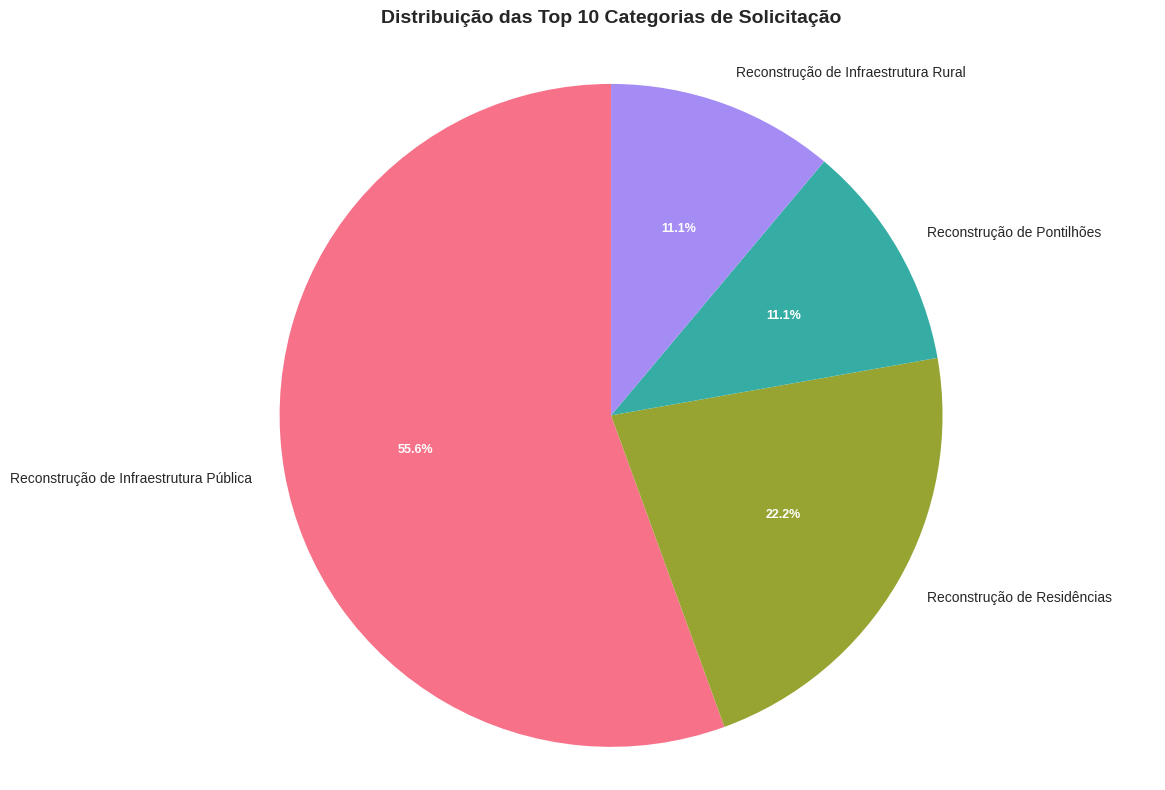

In [22]:
# Gráfico de pizza com as top 10 categorias
top_n = 10
top_categories = category_counts.head(top_n)

# Se houver mais categorias, agrupar as demais em "Outras"
if len(category_counts) > top_n:
    outras = category_counts[top_n:].sum()
    top_categories = pd.concat([top_categories, pd.Series({'Outras': outras})])

# Criar gráfico de pizza
plt.figure(figsize=(12, 8))
colors = sns.color_palette("husl", len(top_categories))
wedges, texts, autotexts = plt.pie(
    top_categories.values,
    labels=top_categories.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    textprops={'fontsize': 9}
)

# Melhorar legibilidade
for text in texts:
    text.set_fontsize(10)
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(9)

plt.title(f'Distribuição das Top {top_n} Categorias de Solicitação', fontsize=14, fontweight='bold', pad=20)
plt.axis('equal')
plt.tight_layout()
plt.show()

### Gráfico de Barras - Frequência de Categorias

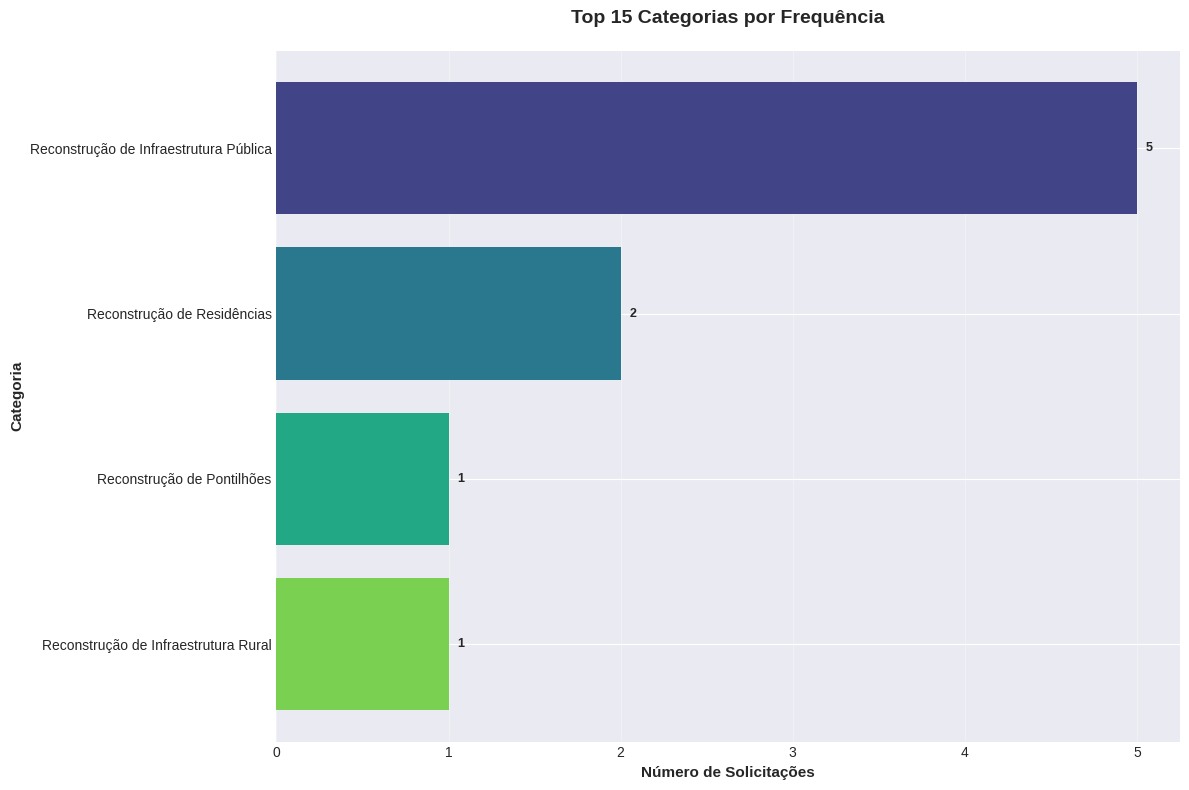

In [23]:
# Gráfico de barras horizontal com top 15 categorias
plt.figure(figsize=(12, 8))
top_15 = category_counts.head(15)

bars = plt.barh(range(len(top_15)), top_15.values, color=sns.color_palette("viridis", len(top_15)))
plt.yticks(range(len(top_15)), top_15.index, fontsize=10)
plt.xlabel('Número de Solicitações', fontsize=11, fontweight='bold')
plt.ylabel('Categoria', fontsize=11, fontweight='bold')
plt.title('Top 15 Categorias por Frequência', fontsize=14, fontweight='bold', pad=20)

# Adicionar valores nas barras
for i, (bar, value) in enumerate(zip(bars, top_15.values)):
    plt.text(value + max(top_15.values) * 0.01, i, f'{value}', 
             va='center', fontsize=9, fontweight='bold')

plt.gca().invert_yaxis()
plt.tight_layout()
plt.grid(axis='x', alpha=0.3)
plt.show()

### Comparação: Solicitações Classificadas vs Vazias

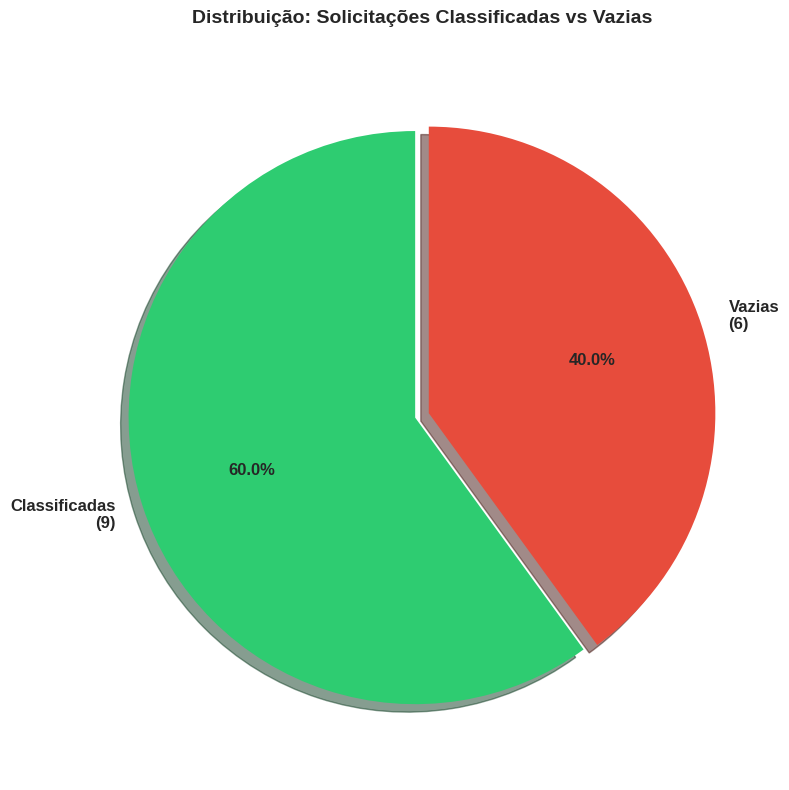


Resumo:
  • Total de registros: 15
  • Solicitações classificadas: 9 (60.0%)
  • Solicitações vazias: 6 (40.0%)


In [24]:
# Contar solicitações classificadas vs vazias
classificadas = len(df_categorias)
vazias = len(df) - classificadas

# Gráfico de pizza para comparação
plt.figure(figsize=(8, 8))
sizes = [classificadas, vazias]
labels = [f'Classificadas\n({classificadas})', f'Vazias\n({vazias})']
colors = ['#2ecc71', '#e74c3c']
explode = (0.05, 0)

plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=90, textprops={'fontsize': 12, 'fontweight': 'bold'})

plt.title('Distribuição: Solicitações Classificadas vs Vazias', 
          fontsize=14, fontweight='bold', pad=20)
plt.axis('equal')
plt.tight_layout()
plt.show()

print(f"\nResumo:")
print(f"  • Total de registros: {len(df)}")
print(f"  • Solicitações classificadas: {classificadas} ({classificadas/len(df)*100:.1f}%)")
print(f"  • Solicitações vazias: {vazias} ({vazias/len(df)*100:.1f}%)")